In [28]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import copy
import matplotlib.pyplot as plt


In [29]:
# Configuration
NUM_CLIENTS = 10
MALICIOUS_FRACTION = 0.4
NUM_ROUNDS = 20
POISON_FRACTION = 1.0
ATTACK_TYPE = "inverted"  # Options: "inverted", "targeted", "random_label", "random_input", "none"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


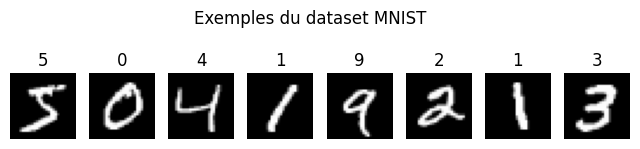

In [40]:
# MNIST loader
mnist_transform = transforms.ToTensor()
mnist_data = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=mnist_transform)

# Affichage
plt.figure(figsize=(8, 2))
for i in range(8):
    image, label = mnist_data[i]
    plt.subplot(1, 8, i+1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(str(label))
    plt.axis('off')
plt.suptitle("Exemples du dataset MNIST")
plt.show()

In [30]:
# Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)


In [31]:
# Dataset
transform = transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)


In [32]:
# Partitioning
client_data = [[] for _ in range(NUM_CLIENTS)]
for i, (x, y) in enumerate(trainset):
    client_data[i % NUM_CLIENTS].append((x, y))


In [33]:
# Inverted loss
def inverted_loss(output, target):
    loss = nn.CrossEntropyLoss()(output, target)
    return 1. / (loss + 1e-6)


In [34]:
# Poisoning strategies
def poison_data(data, attack_type):
    poisoned = []
    for x, y in data:
        if random.random() > POISON_FRACTION or attack_type is None:
            poisoned.append((x, y))
            continue
        if attack_type == "targeted":
            new_y = (y + 1) % 10
        elif attack_type == "random_label":
            new_y = random.randint(0, 9)
        elif attack_type == "random_input":
            x = x + 0.5 * torch.randn_like(x)
            x = torch.clamp(x, 0., 1.)
            new_y = y
        elif attack_type == "inverted":
            new_y = y
        else:
            new_y = y
        poisoned.append((x, new_y))
    return poisoned


In [35]:
# Local training
def local_train(model, data, use_inverted=False, epochs=1, lr=0.05):
    model = copy.deepcopy(model).to(DEVICE)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = inverted_loss if use_inverted else nn.CrossEntropyLoss()
    loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)
    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
    return model.cpu().state_dict()


In [36]:
# Evaluation
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total


In [37]:
# Federated training
global_model = MLP()
acc_list = []


In [38]:
for rnd in range(NUM_ROUNDS):
    local_weights = []
    for i in range(NUM_CLIENTS):
        local_model = MLP()
        local_model.load_state_dict(global_model.state_dict())
        is_malicious = (i < int(NUM_CLIENTS * MALICIOUS_FRACTION))
        attack_mode = ATTACK_TYPE if is_malicious else None
        poisoned_dataset = poison_data(client_data[i], attack_mode)
        weights = local_train(local_model, poisoned_dataset, use_inverted=(is_malicious and ATTACK_TYPE == "inverted"))
        local_weights.append(weights)
    # Aggregation
    new_state_dict = copy.deepcopy(local_weights[0])
    for k in new_state_dict.keys():
        for i in range(1, NUM_CLIENTS):
            new_state_dict[k] += local_weights[i][k]
        new_state_dict[k] = torch.div(new_state_dict[k], NUM_CLIENTS)
    global_model.load_state_dict(new_state_dict)
    acc = evaluate(global_model.to(DEVICE), testloader)
    acc_list.append(acc)
    print(f"Round {rnd+1}: Accuracy = {acc:.4f}")



Round 1: Accuracy = 0.6755
Round 2: Accuracy = 0.7371
Round 3: Accuracy = 0.3149
Round 4: Accuracy = 0.2260
Round 5: Accuracy = 0.2913
Round 6: Accuracy = 0.3628
Round 7: Accuracy = 0.3917
Round 8: Accuracy = 0.4086
Round 9: Accuracy = 0.4123
Round 10: Accuracy = 0.4645
Round 11: Accuracy = 0.4730
Round 12: Accuracy = 0.4693
Round 13: Accuracy = 0.4750
Round 14: Accuracy = 0.4688
Round 15: Accuracy = 0.4922
Round 16: Accuracy = 0.4897
Round 17: Accuracy = 0.4695
Round 18: Accuracy = 0.5281
Round 19: Accuracy = 0.5164
Round 20: Accuracy = 0.5080


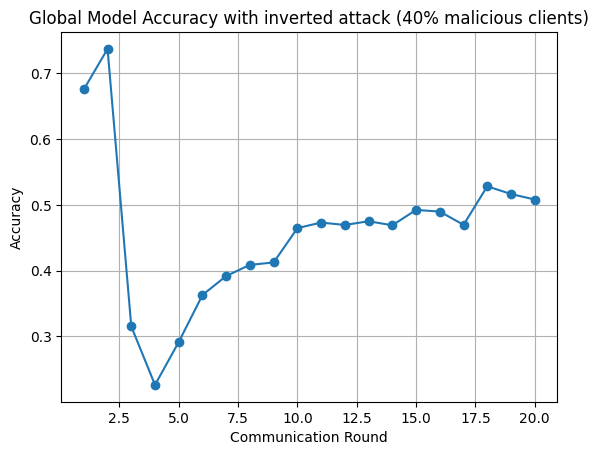

In [39]:
# Plot
plt.plot(range(1, NUM_ROUNDS + 1), acc_list, marker='o')
plt.title(f"Global Model Accuracy with {ATTACK_TYPE} attack ({int(MALICIOUS_FRACTION*100)}% malicious clients)")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
